# Geração de dataset para o problema de trasnporte 1D de fluidos bifásicos em meios porosos.

## Introdução
> O problema em questão é o modelo padrão de Buckley-Leverett, com dois fluidos incompressíveis e imiscíveis. Considerando que os fluidos são $o$ e $w$, a permeabilidade e a porosidade do meio são as funções $k(x)$ e $\phi(x)$, respectivamente, e são desprezíveis os efeitos de gravidade e capilaridade, a pressão $p$ e a saturação dos fluidos $S_w(x,t)$ e $S_o(x,t)$ são dados por um sistema combinando as equações de balanço de massa e a equação de Darcy para cada fase (Fuks e Tchelepi, 2020). A equação abaixo modela esse problema em uma dimensão:
$$\phi(x)\dfrac{\partial S_w}{\partial t} + u_{tot}\dfrac{\partial f_w(S_w)}{\partial x}=0$$.

> Na equação acima, $u_{tot}=u_w+u_o$ é a soma dos fluxos de Darcy de cada fase, e $f_w(S_w)$ é o fluxo fracional de água:
$$f_w = \dfrac{\lambda_w}{\lambda_w + \lambda_o}$$,

> Em que $\lambda_\alpha=(k\cdot k_{rw})/\mu_\alpha$ é a mobilidade de cada fase ($\alpha=o,\;w$), com $\mu_\alpha$ sendo a viscosidade da fase, e $k_{rw}(S_w)$ sendo a permeabilidade relativa de cada fase.

> Para esse problema, as equções iniciais e de fronteira são:
$$S_w(x,t)=s_{wi},\;\forall x,\; t=0\\ S_w(x,t)=s_b,\; x=0,\;t>0$$.

> Utilizando-se das variáveis adimensionais $t=[\int_0^t (u_{tot}dt')]/(\phi L)$ e $x_D=x/L$, a equação do problema e suas condições podem ser reescritas como:
$$\dfrac{\partial S_w}{\partial t_D} + \dfrac{\partial f(S_w)}{\partial x_d}=0\\
S_w(x_D,t_D)=s_{wi},\;\forall x_D,\; t_D0\\ S_w(x_D,t_D)=s_b,\; x_D=0,\;t_D>0$$

> E resolver a equação acima é equivlente a resolver essa PDE hiperbólica:
$$\dfrac{\partial u}{\partial t} + \dfrac{\partial f(u)}{\partial x}=0\\
u(x,t=0)=u_0(x)\\ u(x=0,t)=u_b(t)$$.

> Neste trabalho, são assumidas a condição inicial e de fronteira uniformes:
$$u(x,t=0)=0\\ u(x=0,t>0)=1$$.


## Caso Côncavo - solução numérica
> O caso côncavo da solução para essa PDE ocorre quando a permeabilidade relativa das fases $k_{r\alpha}(S_\alpha)$ é uma função linear da saturação, com a função de fluxo podendo ser reescrita como:
$$f_w(S_w)=\dfrac{S_w}{S_w + S_o\dfrac{\mu_w}{\mu_o}}$$,
Sendo $S_o = 1-S_w$ e $M=\mu_o/\mu_w$, a função $f(u)$ do problema se torna:
$$f(u) = \dfrac{u}{u + \dfrac{1-u}{M}}$$.

> Substituindo essa forma de $f(u)$ na PDE, obtém-se:
$$\dfrac{\partial u}{\partial t} + \dfrac{\partial}{\partial x}\left(\dfrac{u}{u + \dfrac{1-u}{M}}\right)=0$$.

> Com alguma manipulação algébrica, obtém-se:
$$u_t + \dfrac{M}{\left[1 + (M-1)u\right]^2}\cdot u_x = 0$$.

> Esse problema de valor inicial e de contorno pode ser facilmente resolvido com o método de diferenças finitas regressivo:
$$u_x(x_i,t)\approx\dfrac{u_i-u_{i-1}}{\Delta x}\Rightarrow u_t(x_i) \approx \dfrac{-M}{\left[1 + (M-1)u_i\right]^2}\cdot\dfrac{u_i-u_{i-1}}{\Delta x}$$

> Com a integração de Euler, pode-se então fazer:
$$u(x_i,t)\approx u(x_i,t-\Delta t) + \Delta t\cdot\dfrac{-M}{\left[1 + (M-1)u_i\right]^2}\cdot\dfrac{u_i-u_{i-1}}{\Delta x}$$

## Caso não-convexo - Solução numérica
> Para o caso não-convexo da solução, é assumido que a permeabilidade relativa segue uma lei de potência em função da saturação, mais especificamente, segue uma relação quadrática. Dessa forma, a função $f(u)$ pode ser reescrita assim:
$$f(u) = \dfrac{u^2}{u^2 + \dfrac{(1-u)^2}{M}}$$.

> E a nova PDE é:
$$u_t + \dfrac{2Mu(1-u)}{\left[(M+1)u^2 -2u +1\right]^2}\cdot u_x = 0$$.

> Ainda utilizando o método de diferenças finitas regressivo e integração de Euler, obtém-se:
$$u(x_i,t)\approx u(x_i,t-\Delta t) + \Delta t\cdot\dfrac{-2Mu(1-u)}{\left[(M+1)u^2 -2u +1\right]^2}\cdot\dfrac{u_i-u_{i-1}}{\Delta x}$$

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib.lines import Line2D

In [2]:
mpl.rcParams['font.family'] = 'arial'
mpl.rc('font', size=9)

In [54]:
def utt(uu, du, cc):
    global M
    if cc=='concavo':
        return (-M/(1 + (M-1)*uu)**2)*du
    elif cc=='nao-convexo':
        return (-2*M*uu*(1-uu)/((M+1)*uu**2 -2*uu +1)**2)
    else:
        return 0

In [61]:
## Solucoes
# Parametros do MDF
nt = 1e3                    # numero de snapshots
dt = 1/nt                   # passo temporal
t = np.linspace(0, 1, int(nt))     # vetor tempo
nx = 200                   # numero de nos
dx = 1/nx                  # passo espacial
x = np.linspace(0, 1, int(nx))     # espaço discretizado

# Parametros problema
u0 = np.zeros(x.shape)
u_x0 = 1
M = 1

# Caso concavo
uk1 = u0
u = np.array([uk1])
for k in range(1, int(nt)):
    uk = np.array([u_x0])
    for i in range(1, int(nx)):
        ux = (uk1[i]-uk1[i-1])/dx
#         ut = -M*ux/(1 + (M-1)*uk1[i])**2
        ut = utt(uk1[i], ux, 'nao-convexo')
        ui = uk1[i] + ut*dt
        uk = np.append(uk, ui)
    uk1 = uk
    u = np.append(u, [uk], axis=0)

sw = u
so = 1-u

# solucoes: matriz com snapshots de sw ou so (em funcao de x) para cada instante do vetor tempo
# sw = np.array([np.sin(2*np.pi*x-2*np.pi*tt/4) + 1.3 for tt in t])
# so = np.array([np.sin(4*np.pi*x+np.pi-2*np.pi*tt/6) + 1.5 for tt in t])

<IPython.core.display.Javascript object>


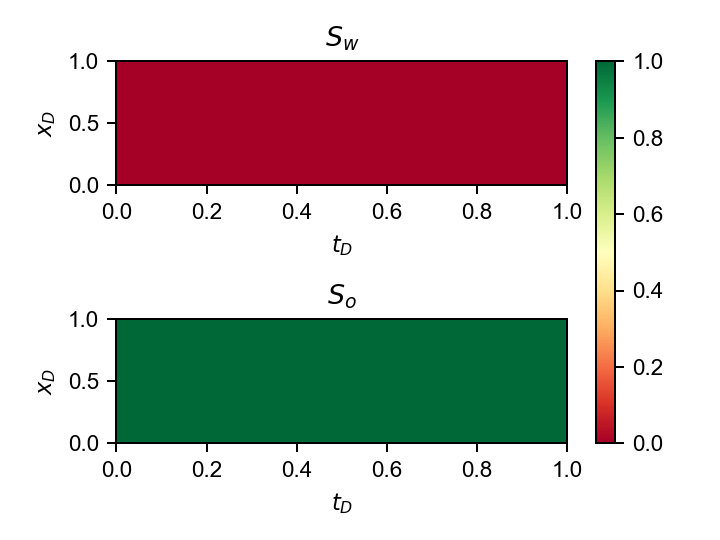

In [60]:
# Plot 2D estatico
fig1, ax1 = plt.subplots(2, 1, figsize=(4, 3), dpi=180)
norm = mpl.colors.Normalize(min(np.min(so), np.min(sw)), max(np.max(sw), np.max(so)))
c = ax1[0].pcolor(t, x, sw.T, cmap='RdYlGn', norm=norm)
ax1[1].pcolor(t, x, so.T, cmap='RdYlGn', norm=norm)

# Ajustes do plot
ax1[0].set_title('$S_w$')
ax1[1].set_title('$S_o$')

# Legenda e eixos
for i in range(2):
    ax1[i].set_ylabel('$x_D$')
    ax1[i].set_xlabel('$t_D$')
    ax1[i].set_ylim(0, 1)
    ax1[i].set_xlim(0, 1)
fig1.tight_layout()
fig1.colorbar(c, ax=ax1)


<IPython.core.display.Javascript object>


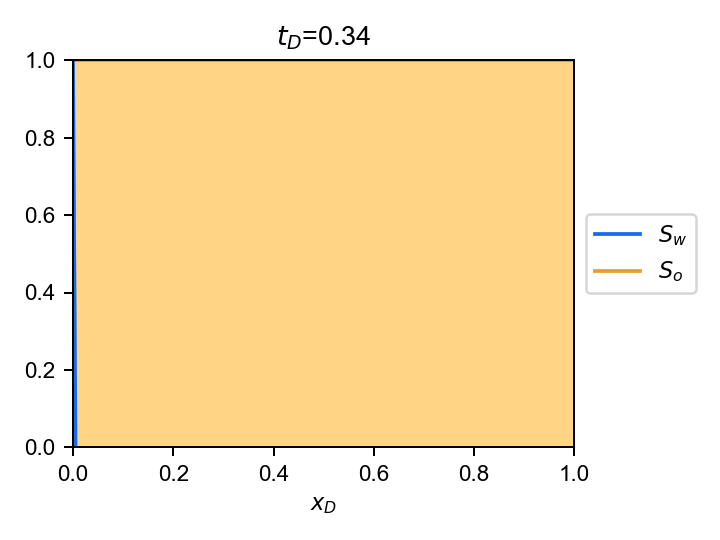

In [64]:
# Animacao
fig2, ax2 = plt.subplots(figsize=(4, 3), dpi=180)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 5)
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

def anifunc(frame):
    global x, sw, so, dt
    # Plot
    ax2.clear()
    ax2.fill_between(x, sw[frame]+so[frame], sw[frame], ec='#e6a122', fc='#ffd485')
    ax2.fill_between(x, sw[frame], ec='#156ced', fc='#85b6ff')
    
    # Ajustes do plot
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel('$x_D$')
    ax2.set_title('$t_D$={t:.2f}'.format(t=frame/nt))
    
    # Legenda
    legenda = [Line2D([0], [0], color='#156ced', label='$S_w$'),
               Line2D([0], [0], color='#e6a122', label='$S_o$')]
    ax2.legend(handles=legenda, loc='center left', bbox_to_anchor=(1, 0.5))
    fig2.tight_layout()
    return []


ani = FuncAnimation(fig2, anifunc, frames=int(1/dt), interval=5/nt)